# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа необходимо:
- Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
- А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

- Тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок.
- Тест для категориальных признаков.

Данные содержат следующие столбцы:
*  *work_year* - 	Год, в котором была выплачена зарплата.
*  *experience_level* - Опыт работы на этой должности в течение года со следующими возможными значениями:
                             EN — Entry-level/Junior;
                             MI — Mid-level/Intermediate;
                             SE — Senior-level/Expert;
                             EX — Executive-level/Director.
* *employment_type* - Тип трудоустройства для этой роли:
                             PT — неполный рабочий день;
                             FT — полный рабочий день;
                             CT — контракт;
                             FL — фриланс.            
* *job_title* - Роль, в которой соискатель работал в течение года.
* *salary* - 	Общая выплаченная валовая сумма заработной платы.
* *salary_currency* - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* *salary_in_usd* - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* *employee_residence* - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* *remote_ratio* - Общий объём работы, выполняемой удалённо. Возможные значения:
                             0 — удалённой работы нет (менее 20 %);
                             50 — частично удалённая работа;
                             100 — полностью удалённая работа (более 80 %).            
* *company_location* - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* *company_size* - Среднее количество людей, работавших в компании в течение года:
                             S — менее 50 сотрудников (небольшая компания);
                             M — от 50 до 250 сотрудников (средняя компания);
                             L — более 250 сотрудников (крупная компания).      

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# оставим это как было в примере:
sns.set_theme('notebook') 
sns.set_palette('Set2')

C:\Users\Professional\AppData\Local\Temp\ipykernel_6364\3402423164.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('data/EDA_practik.zip', index_col=[0])
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## 1 Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [5]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Определяем в данных неинформативные признаки, которые не будут участвовать в исследовании и удаляем их



In [6]:
data.drop(['salary','salary_currency'],axis=1,inplace=True)

Из предоставленого ддатасета убираем два признака это 'salary' и 'salary_currency' которые отвечают за размер зарплаты и её валюту, т.к. в датасете уже есть признак 'salary_in_usd' он более удобен т.е. приводит все зарплаты к единому виду.

Классифицирование всех признаков на числовые и категориальные

* *work_year* - числовой.
* *experience_level* - категориальные.
* *employment_type* - категориальные.
* *job_title* - категориальные.
* *salary_in_usd* - числовой.
* *employee_residence* - категориальные.
* *remote_ratio* - категориальные.
* *company_location* - категориальные.
* *company_size* - категориальные.

Нахождение основных статистических характеристик для каждого из признаков.

In [7]:
data.describe(include='all' )

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,565,565.000000,565,565.000000,565,565
unique,NaN,4,4,50,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,US,NaN,US,M
freq,NaN,243,546,130,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,150000.000000,NaN,100.000000,NaN,NaN


## 2.1 Разведывательный анализ данных

work_year - год получения данных и salary_in_usd помогут нам определить рост зарплаты в принципе, а также ответить на первый вопрос "Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?"

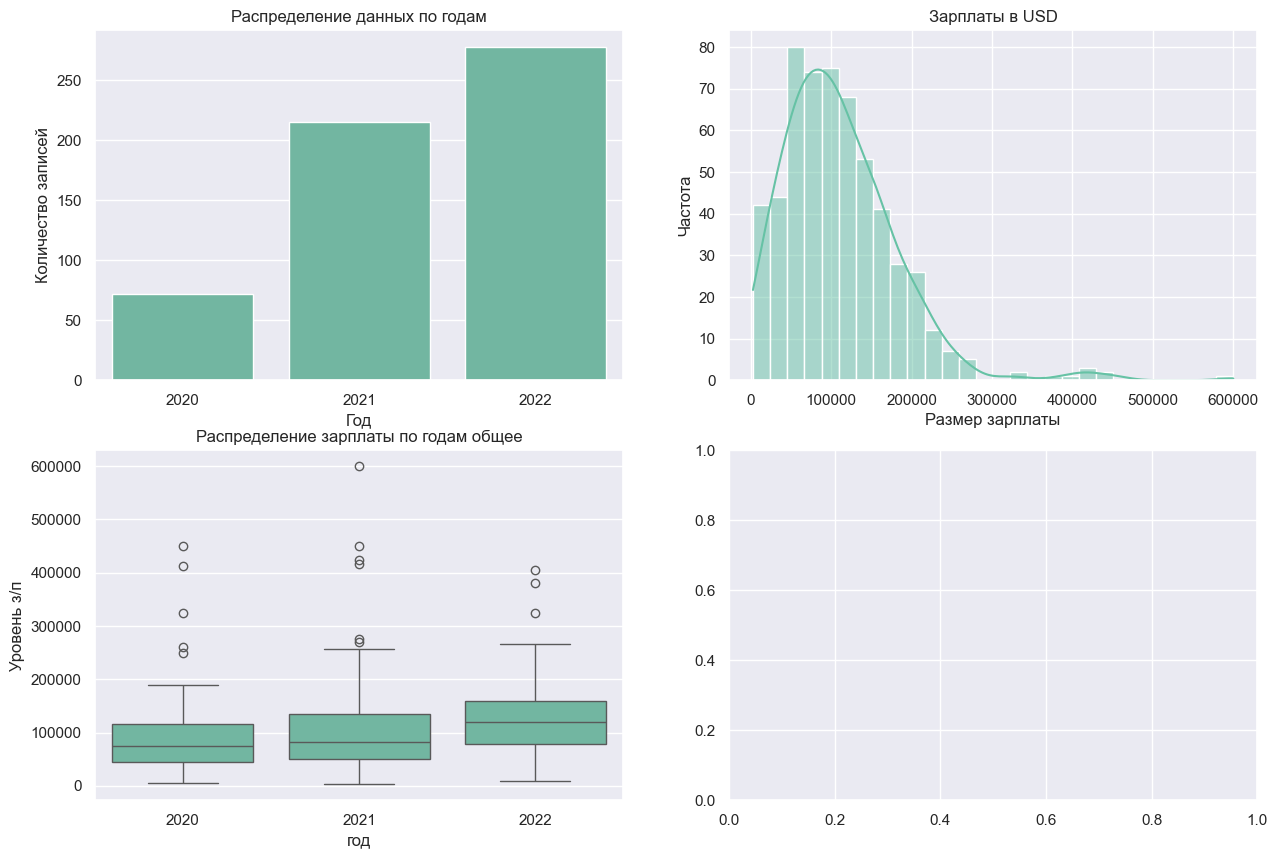

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0][0] = sns.countplot(data, x='work_year', ax=axes[0][0])
axes[0][0].set(xlabel='Год', ylabel='Количество записей')
axes[0][0].set_title('Распределение данных по годам')


axes[0][1] = sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0][1])
axes[0][1].set(xlabel='Размер зарплаты', ylabel='Частота')
axes[0][1].set_title('Зарплаты в USD')

axes[1][0] = sns.boxplot(data, x='work_year', y='salary_in_usd', ax=axes[1][0])
axes[1][0].set(xlabel='год', ylabel='Уровень з/п')
axes[1][0].set_title('Распределение зарплаты по годам общее')

plt.show()

Из полученных графиков можно сделать следующие выводы:
 - Большинство кол.-во полученных записей приходится на 2021 и 2022 год (график "Распределение данных по годам").
 - Распределение заработной платы в USD имеет выбросы, есть 2 вершины, следовательно распределение не является нормальный, также видим, что основное количество записей приходится на диапазон     50-100 тыс. долларов в год (график "Зарплаты в USD").

Влияние уровеня квалификации на зарплат у специалистов Data Scientist?

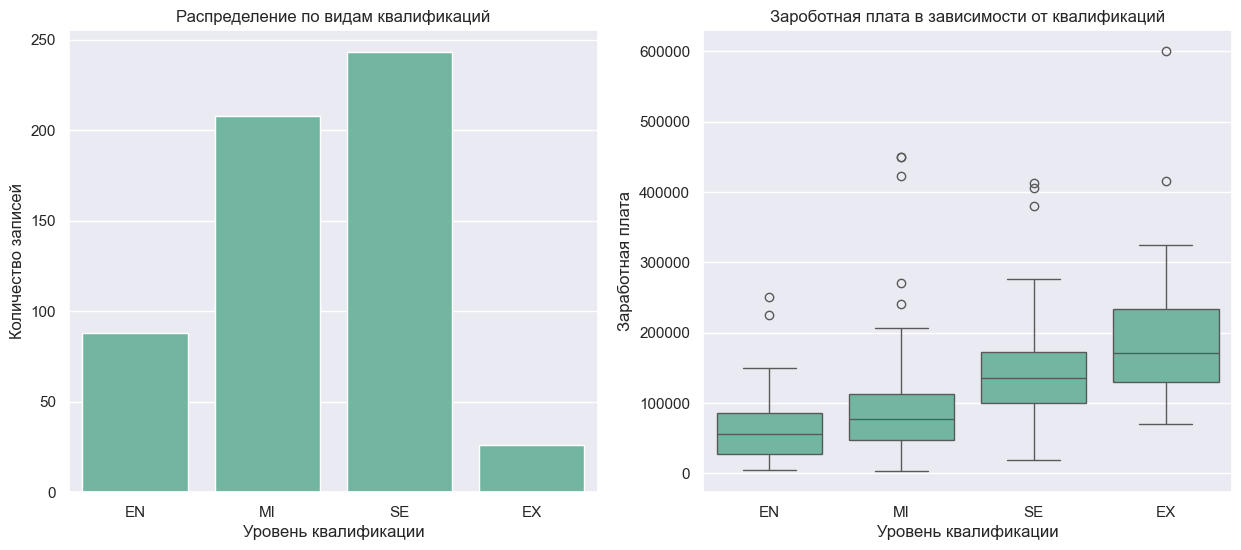

In [11]:
order = ['EN', 'MI', 'SE', 'EX']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0] = sns.countplot(data, x='experience_level', order = order, ax=axes[0])
axes[0].set(xlabel='Уровень квалификации', ylabel='Количество записей')
axes[0].set_title('Распределение по видам квалификаций')


axes[1] = sns.boxplot(data, x='experience_level', y='salary_in_usd', order = order, ax=axes[1])
axes[1].set(xlabel='Уровень квалификации', ylabel='Заработная плата')
axes[1].set_title('Зароботная плата в зависимости от квалификаций')

plt.show()

Согласно полученных графиков видно: 
- Что больше всего специальностей находится в грумме MI и SE (мидл и сеньер), очень мало уровня эксперта. 
- Уровень заработной платы растет в зависимости от уровня квалификации. Так медианный уровень заработной платы каждого последующего уровня примерно равен или выше верхнего квантиля предыдущего уровня.
- Наибольшия з/п у спуциалиста уровня EX (эксперт).

Страна проживания сотрудника

Text(0.5, 1.0, 'Уровень з/п в зависимость от страны')

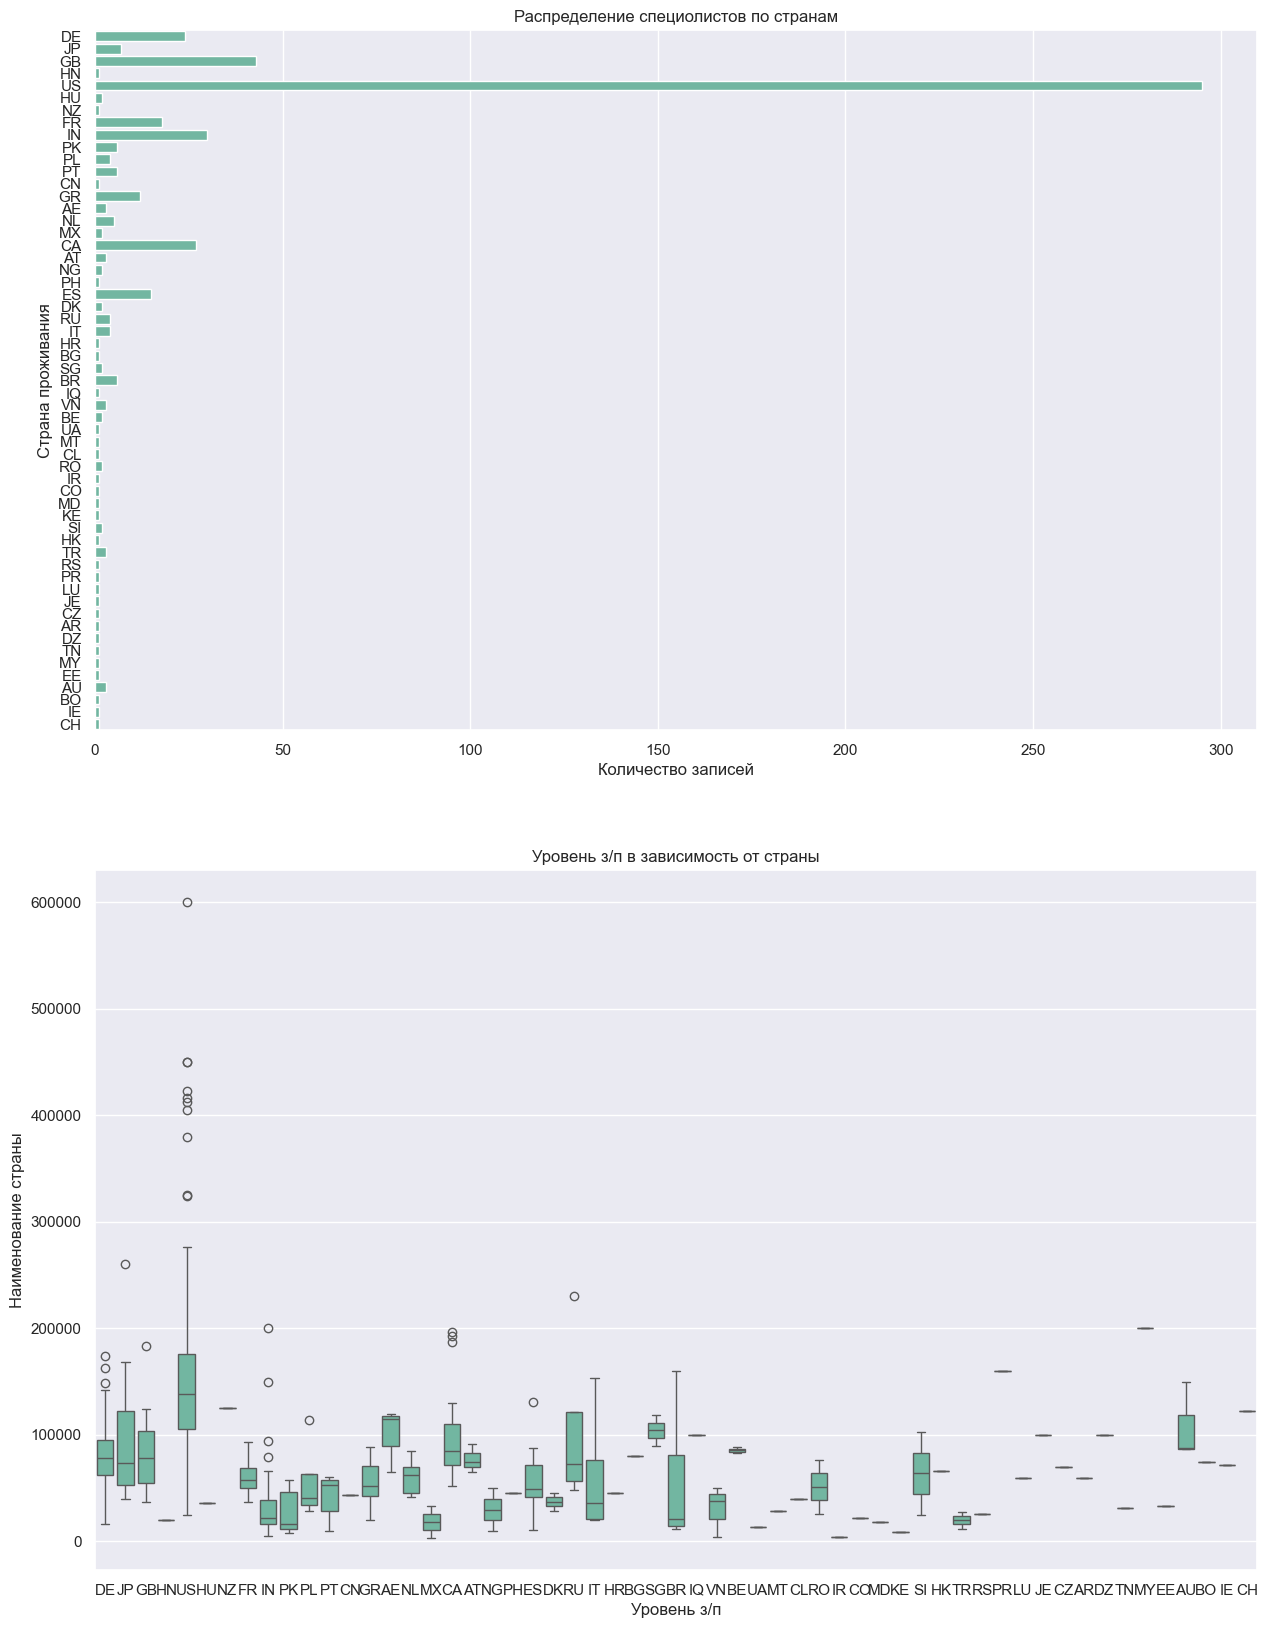

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

axes[0] = sns.countplot(data, y='employee_residence', ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Страна проживания')
axes[0].set_title('Распределение специолистов по странам')


axes[1] = sns.boxplot(data, y='salary_in_usd', x='employee_residence', ax=axes[1])
axes[1].set(xlabel='Уровень з/п', ylabel='Наименование страны')
axes[1].set_title('Уровень з/п в зависимость от страны')

На полученных графиках видно, что большинство сотрудников работают в US (США), самый высокий уровенб заработной платы находится там же, что указывает на возможную коррелируемочть признаков друг с другом.

Страна офиса работодателя

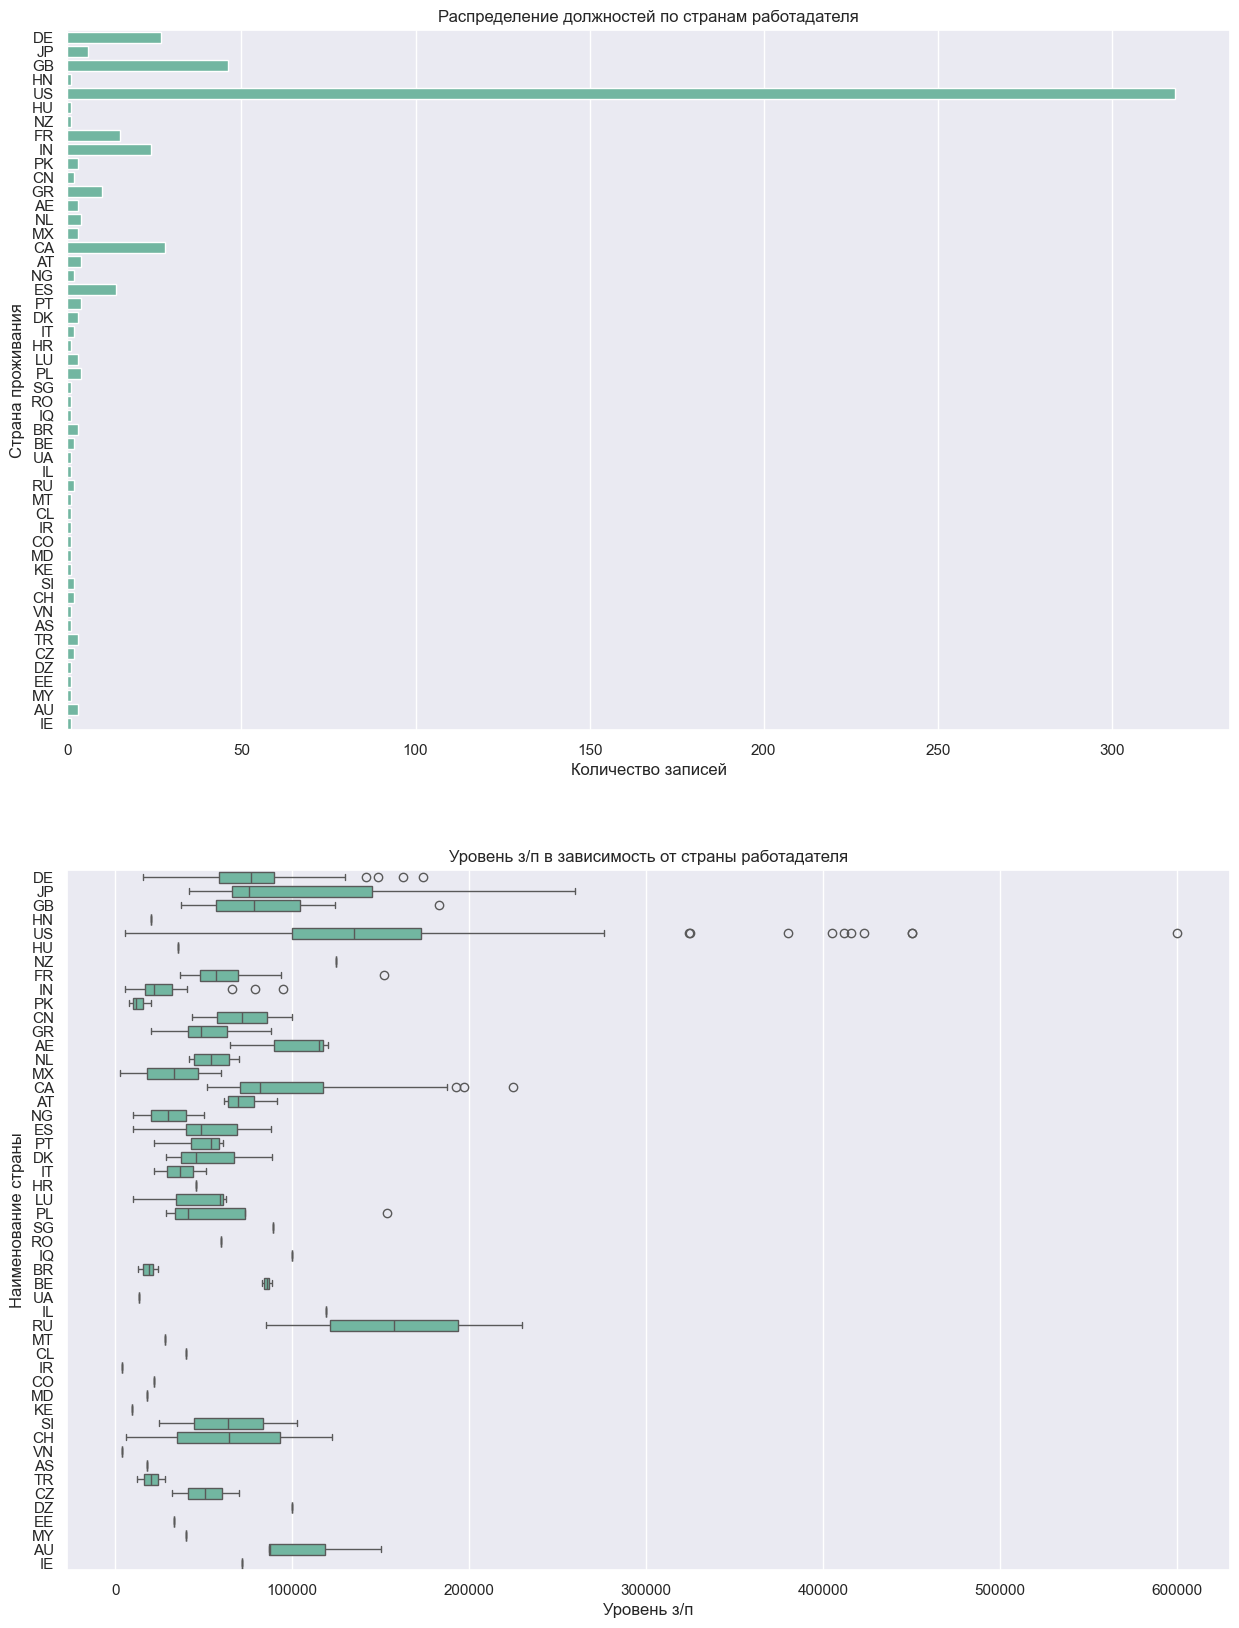

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

axes[0] = sns.countplot(data, y='company_location', ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Страна проживания')
axes[0].set_title('Распределение должностей по странам работадателя')


axes[1] = sns.boxplot(data, y='company_location', x='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='Уровень з/п', ylabel='Наименование страны')
axes[1].set_title('Уровень з/п в зависимость от страны работадателя')

plt.show()

Наибольшее количество работодателей находяться в US (США), при этом по уровню зарплат они на втором месте после RU (Россия). Тройку лидеров закрывает JP (Япония).

Должность на которой соискатель работал в течение года

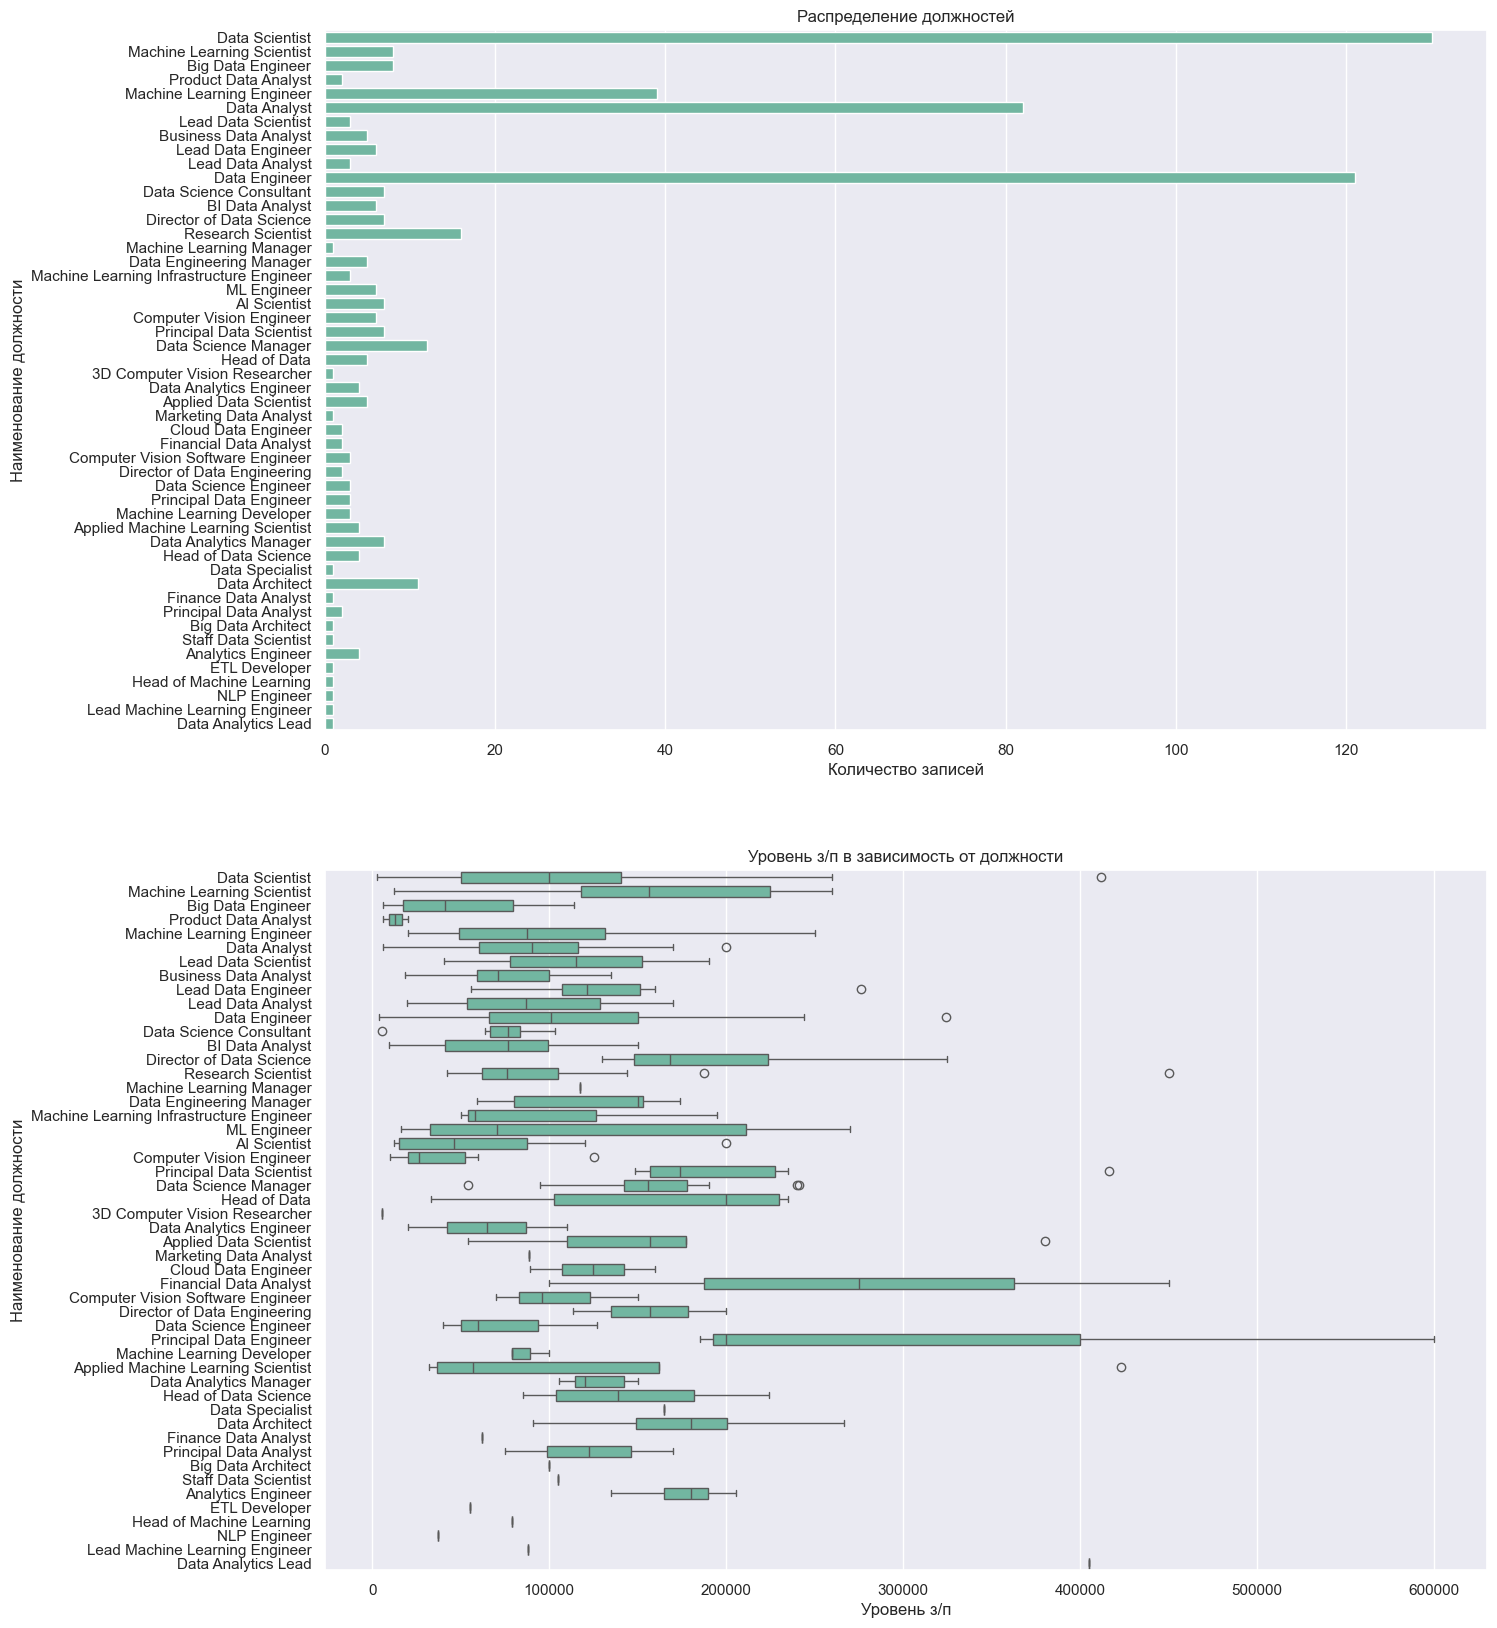

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

axes[0] = sns.countplot(data, y='job_title', ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Наименование должности')
axes[0].set_title('Распределение должностей')


axes[1] = sns.boxplot(data, y='job_title', x='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='Уровень з/п', ylabel='Наименование должности')
axes[1].set_title('Уровень з/п в зависимость от должности')

plt.show()

На построенных графиках видно:
- ТОП-5 профессий состовляют: 
      Data Scientist;
      Data Engineer;
      Data Analyst;
      Maschine Learning Engineer, Research Scientist.
- Уровень заработной платы у этих профессий находится примерно в одной плоскости по отношению к другим.
- Самые высокооплачиваемые профессии это Principal Data Scientist и Financial Data Analyst.

Объём работы выполняемой удалённо

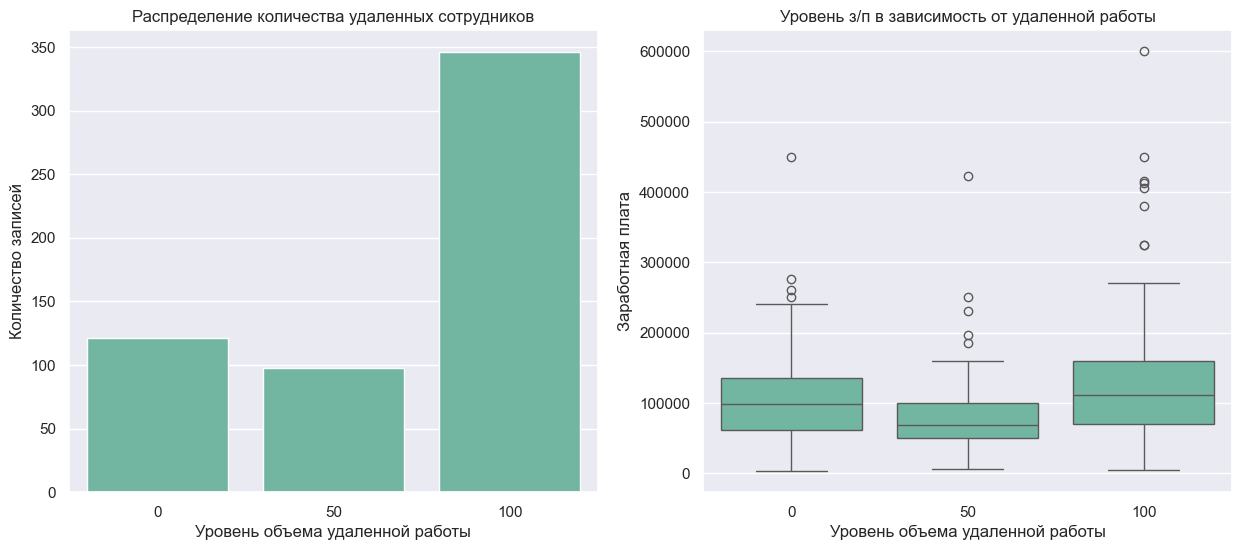

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0] = sns.countplot(data, x='remote_ratio', ax=axes[0])
axes[0].set(xlabel='Уровень объема удаленной работы', ylabel='Количество записей')
axes[0].set_title('Распределение количества удаленных сотрудников')


axes[1] = sns.boxplot(data, x='remote_ratio', y='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='Уровень объема удаленной работы', ylabel='Заработная плата')
axes[1].set_title('Уровень з/п в зависимость от удаленной работы')

plt.show()

На графиках видем, что приобладает полностью удаленная работа, при этом з/п у данных сотрудников выше чем у остальных и примерно сопоставима с теми, кто работает в офисе

Размер компании

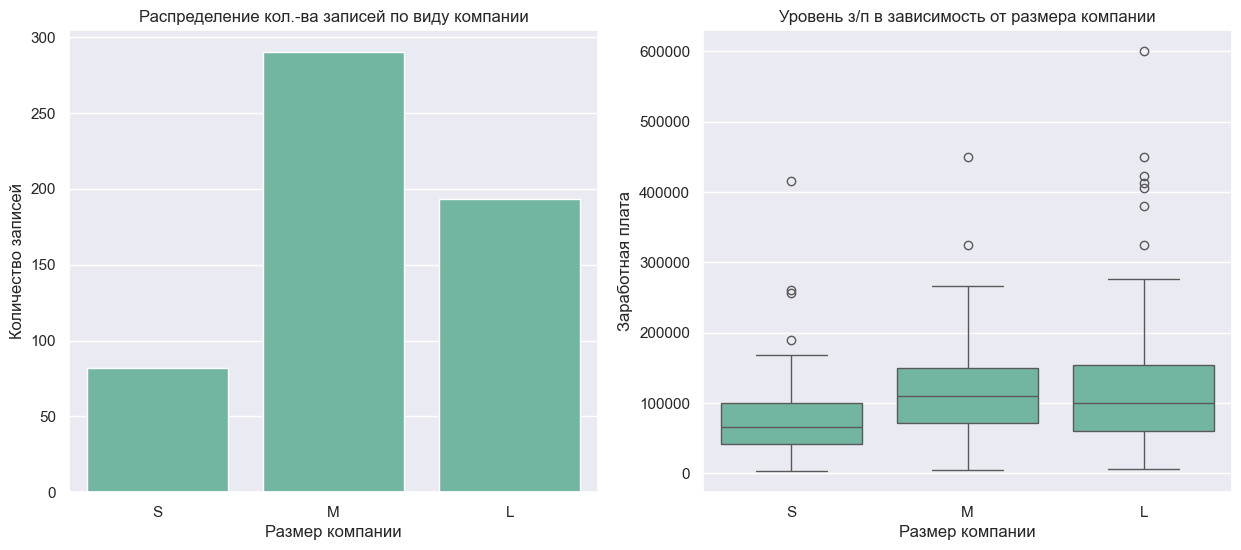

In [20]:
order_size = ['S', 'M', 'L']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0] = sns.countplot(data, x='company_size', order = order_size, ax=axes[0])
axes[0].set(xlabel='Размер компании', ylabel='Количество записей')
axes[0].set_title('Распределение кол.-ва записей по виду компании')


axes[1] = sns.boxplot(data, x='company_size', y='salary_in_usd', order = order_size, ax=axes[1])
axes[1].set(xlabel='Размер компании', ylabel='Заработная плата')
axes[1].set_title('Уровень з/п в зависимость от размера компании')

plt.show()

Согласно полученным графикам видем:
- Больше всего специалистов занятов с средних компаниях.
- Медиана з/п специалиста в средней компании выше, чем в маленьких и больших.

Уровень з/п Data Scientist и  Data Engineer в зависимость от размера компании

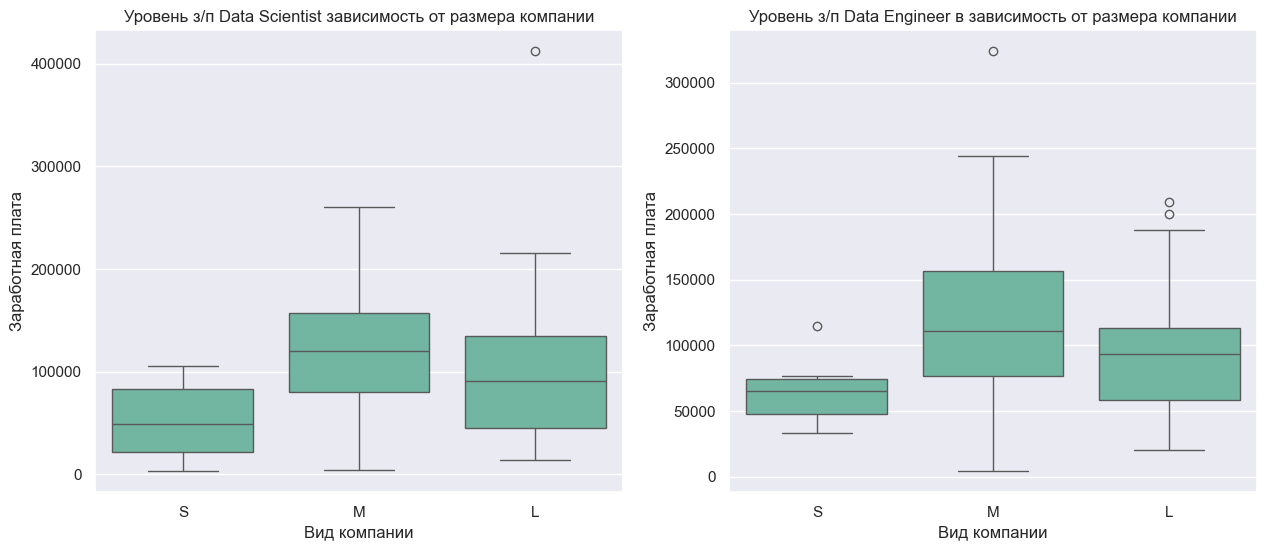

In [42]:
order_size = ['S', 'M', 'L']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[1] = sns.boxplot(data[data['job_title'] == 'Data Engineer'], x='company_size', y='salary_in_usd', order = order_size, ax=axes[1])
axes[1].set(xlabel='Вид компании', ylabel='Заработная плата')
axes[1].set_title('Уровень з/п Data Engineer в зависимость от размера компании')

axes[0] = sns.boxplot(data[data['job_title'] == 'Data Scientist'], x='company_size', y='salary_in_usd', order = order_size, ax=axes[0])
axes[0].set(xlabel='Вид компании', ylabel='Заработная плата')
axes[0].set_title('Уровень з/п Data Scientist зависимость от размера компании')

plt.show()

Уровень з/п Data Scientist и Data Engineer по годам

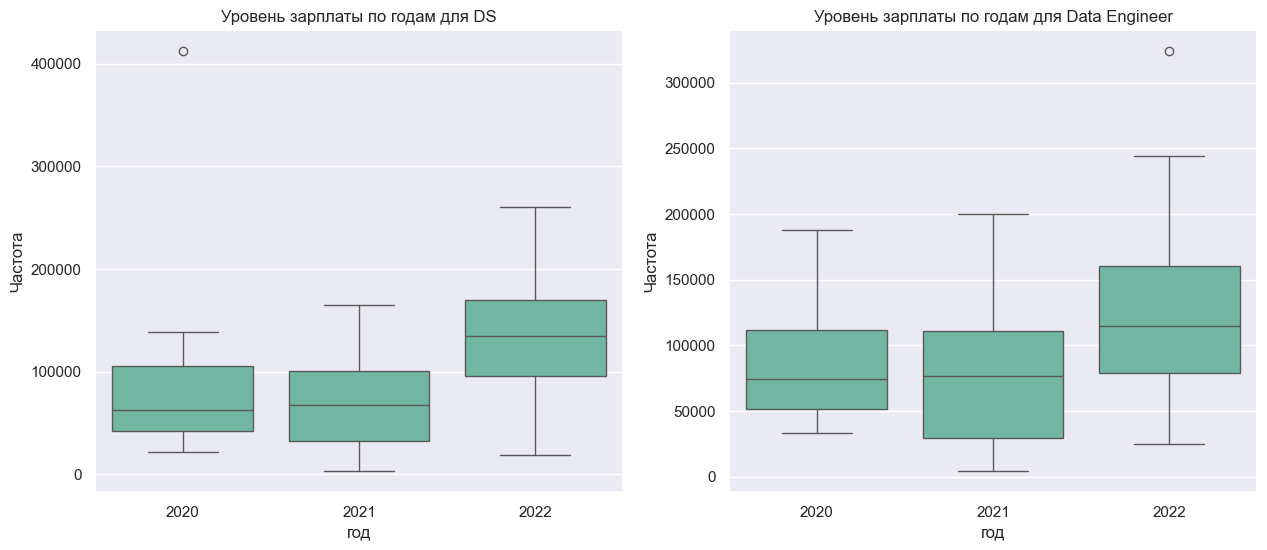

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0] = sns.boxplot(data[data['job_title'] == 'Data Scientist'], x='work_year', y='salary_in_usd', ax=axes[0])
axes[0].set(xlabel='год', ylabel='Частота')
axes[0].set_title('Уровень зарплаты по годам для DS')

axes[1] = sns.boxplot(data[data['job_title'] == 'Data Engineer'], x='work_year', y='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='год', ylabel='Частота')
axes[1].set_title('Уровень зарплаты по годам для Data Engineer')

plt.show()

Количество специолистов в областе Data Scientist и Data Engineer в зависимость от размера компании

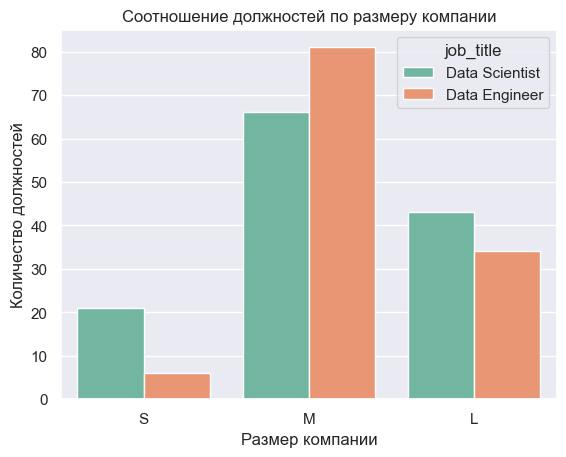

In [41]:
data_ds_de = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]

ax = sns.countplot(data=data_ds_de, x=data_ds_de['company_size'], hue='job_title', order = order_size)
ax.set(xlabel='Размер компании', ylabel='Количество должностей')
plt.title('Соотношение должностей по размеру компании')

plt.show()

Вывод по разделу:

- Согласно построенныем графикам мы можем наблюдать ежегодный рост зарплат у специалистов Data Scientist.
- Одними из факторов влияющих на зарплату у специалистов Data Scientist являються размер компании и страна трудоустройства.
- Заработная плата Data Scientist и Data Engineer зависит от размера компании, больше всего з/п в средних и больших компаниях. Однако заметно, что зарплата у Data Engineer выше, чем у Data Scientist
- Наибольшее кол.-во Data Engineer и Data Scientist в средних компаниях, при этом кол.-во Data Engineer в средних компаниях выще чем кол.-во Data Scientist. В то же время в больших и малых компаниях кол.-во Data Scientist превышает кол.-во Data Engineer.
- Уровень зарплаты у Data Engineer в 2022г. выше чем у Data Scientist, при этом медиана з/п находиться примерно на одном уровне.
- Помимо всего ранее сказано уровень самого специалиста а так же тип занятости так же влияют на конечную з/п.

## 2.2 Статистический анализ данных

In [44]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      
# функция для проверки на равенство диспесий
def decision_dispersion(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
    else:
        print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

Нулевая гипотеза: распределение данные является нормальным.

Альтернативная гипотеза: распределение данных отлично от нормального.

In [45]:
data_ds_20 = data[(data['job_title'] == 'Data Scientist') & (data['work_year']==2020)]
data_ds_21 = data[(data['job_title'] == 'Data Scientist') & (data['work_year']==2021)]
data_ds_22 = data[(data['job_title'] == 'Data Scientist') & (data['work_year']==2022)]

In [46]:
print('2020 год:')
decision_normality(stats.shapiro(data_ds_20['salary_in_usd'])[1])
print('\n2021 год:')
decision_normality(stats.shapiro(data_ds_21['salary_in_usd'])[1])
print('\n2022 год:')
decision_normality(stats.shapiro(data_ds_22['salary_in_usd'])[1])

2020 год:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

2021 год:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

2022 год:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


У нас есть выборка с распределением отличным от нормального.
Выбираем Критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах) является обобщением U-критерия Манна — Уитни на случай нескольких групп. Его используют, чтобы оценить различия медиан признака в двух и более независимых группах.

Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза: размер медианы зарплаты специалиста Data Science в 2020, 2021 и 2022 годах одинаковые


Альтернативная гипотеза: размер медианы зарплаты специалиста Data Science в 2020, 2021 и 2022 годах отличаются




In [47]:
_, p = stats.kruskal(data_ds_20['salary_in_usd'], data_ds_21['salary_in_usd'], data_ds_22['salary_in_usd'])
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [48]:
data_ds_20['salary_in_usd'].median() < data_ds_21['salary_in_usd'].median() < data_ds_22['salary_in_usd'].median() 

True

Вывод:
- Ответом на вопрос "Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist": - да, наблюдается! Медианные значения растут из года в год, статистическая значимость гипотезы подтверждена

# Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка

In [50]:
data_ds_22 = data[(data['job_title'] == 'Data Scientist') & (data['work_year']==2022)]
data_de_22 = data[(data['job_title'] == 'Data Engineer') & (data['work_year']==2022)]

print('\n2022 год:')
decision_normality(stats.shapiro(data_ds_22['salary_in_usd'])[1])
print('\n2022 год:')
decision_normality(stats.shapiro(data_de_22['salary_in_usd'])[1])


2022 год:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

2022 год:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


У нас есть выборка с распределением отличным от нормального.
Выбираем Критерий МАННА — УИТНИ который используют, чтобы оценить различия распределений признака в двух независимых группах.

Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза: размер зарплаты специалиста Data Scientist меньше или равен размеру зарплаты специалиста Data Engineer в 2022 году

Альтернативная гипотеза: размер зарплаты специалиста Data Science больше размера зарплаты специалиста Data Engineer в 2022 году отличаются

In [51]:
_, p = stats.mannwhitneyu(data_ds_22['salary_in_usd'], data_de_22['salary_in_usd'])
decision_hypothesis(p)

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [55]:
data_ds_22['salary_in_usd'].median() != data_de_22['salary_in_usd'].median() 

True

Вывод:
- Ответ на вопрос "Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?": размер зарплаты специалиста Data Science меньше размера зарплаты специалиста Data Engineer.

# Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

для  Data Scientist

In [58]:
data_ds_S = data[(data['job_title'] == 'Data Scientist') & (data['company_size']=='S')]
data_ds_M = data[(data['job_title'] == 'Data Scientist') & (data['company_size']=='M')]
data_ds_L = data[(data['job_title'] == 'Data Scientist') & (data['company_size']=='L')]

In [59]:
print('\nДля компании S:')
decision_normality(stats.shapiro(data_ds_S['salary_in_usd'])[1])
print('\nДля компании M:')
decision_normality(stats.shapiro(data_ds_M['salary_in_usd'])[1])
print('\nДля компании L:')
decision_normality(stats.shapiro(data_ds_L['salary_in_usd'])[1])


Для компании S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для компании M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для компании L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


для Data Engineer

In [56]:
data_de_S = data[(data['job_title'] == 'Data Engineer') & (data['company_size']=='S')]
data_de_M = data[(data['job_title'] == 'Data Engineer') & (data['company_size']=='M')]
data_de_L = data[(data['job_title'] == 'Data Engineer') & (data['company_size']=='L')]

In [57]:
print('\nДля компании S:')
decision_normality(stats.shapiro(data_de_S['salary_in_usd'])[1])
print('\nДля компании M:')
decision_normality(stats.shapiro(data_de_M['salary_in_usd'])[1])
print('\nДля компании L:')
decision_normality(stats.shapiro(data_de_L['salary_in_usd'])[1])


Для компании S:
p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для компании M:
p-value = 0.085
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для компании L:
p-value = 0.109
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [60]:
# проверка равенство дисперсий только S и M компаний, т.к. у L компаний распределение для DS не является нормальным и точно будет использоваться непараметрический тест
print('\nДля компании S:')
result = stats.levene(data_ds_S['salary_in_usd'], data_de_S['salary_in_usd'])
decision_dispersion(result[1])
print('\nДля компании M:')
result = stats.levene(data_ds_M['salary_in_usd'], data_de_M['salary_in_usd'])
decision_dispersion(result[1])


Для компании S:
p-value = 0.348
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Для компании M:
p-value = 0.689
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


Выберем подходящий статистический тест для сравнения L компаний

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака «Размер заработной платы»? — Количественный.
- Сколько сравниваемых групп? — Две.
- Группы зависимы? — Нет.
- Признак распределён по нормальному закону? — Нет.
Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

Выберем подходящий статистический тест для сравнения S и M компаний

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака «Размер заработной платы»? — Количественный.
- Сколько сравниваемых групп? — Две.
- Группы зависимы? — Нет.
- Признак распределён по нормальному закону? — ДА.
- Дисперсии одинаковы - Да
Чтобы проверить нашу гипотезу, можно использовать Двухвыборочный T-КРИТЕРИЙ.

Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза: размер зарплаты специалиста Data Science меньше или равен размеру зарплаты специалиста Data Engineer

Альтернативная гипотеза: размер зарплаты специалиста Data Science больше размера зарплаты специалиста Data Engineer

In [61]:
print('\nДля компании L:')
_, p = stats.mannwhitneyu(data_ds_L['salary_in_usd'], data_de_L['salary_in_usd'], alternative='greater')
decision_hypothesis(p)
print('\nДля компании M:')
_, p = stats.ttest_ind(data_ds_M['salary_in_usd'], data_de_M['salary_in_usd'], alternative='greater', equal_var=True)
decision_hypothesis(p)
print('\nДля компании S:')
_, p = stats.ttest_ind(data_ds_S['salary_in_usd'], data_de_S['salary_in_usd'], alternative='greater', equal_var=True)
decision_hypothesis(p)


Для компании L:
p-value = 0.451
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

Для компании M:
p-value = 0.430
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

Для компании S:
p-value = 0.827
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод:
- Ответ на вопрос "Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?": во всех видах компаний размер зарплаты специалиста Data Science меньше или равен размеру зарплаты специалиста Data Engineer. Потому основания для утверждения, что з/п специалистов Data Scientist больше чем з/п специалистов Data Engineer в компаниях, нет.

# Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

У нас уже есть таблица для DS и DE, будем ее использовать:

In [62]:
table = pd.crosstab(data_ds_de['job_title'], data_ds_de['company_size'])
table
# строить тепловую карту не целесообразно, размер таблицы 2 на 2

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза: признаки «Должность» и «Размер компании» независимы.

Альтернативная гипотеза: признаки «Должность» и «Размер компании» взаимосвязаны

Выберем подходящий статистический тест

Будем использовать Критерий хи-квадрат

In [63]:
# проведем тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод:
- Ответ на вопрос "Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?": да, дання взаимосвязь между размером компании и должностями Data Scientist и Data Engineer присудствует.

## 3. Дополнительное исследование

# Как соотноситься зарплата специалистов DS, проживающих в США и средней зарплаты этих специалистов по всем странам?

Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза: средний уровень зарплаты специалистов DataScience, проживающих в США ниже или равена среднему уровню зарплат по всем странам.

Альтернативная гипотеза: средний уровень зарплаты специалистов DataScience, проживающих в США выше среднего уровня зарплат по всем странам.

Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

In [64]:
data_ds_all = data[data['job_title']=='Data Scientist']
data_ds_us = data[(data['job_title']=='Data Scientist') & (data['employee_residence']=='US')]


print('Для специалистов DataScience вообще:')
result = stats.shapiro(data_ds_all['salary_in_usd'])
decision_normality(result[1])

print('\nДля специалистов DataScience в США:')
result = stats.shapiro(data_ds_us['salary_in_usd'])
decision_normality(result[1])

Для специалистов DataScience вообще:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для специалистов DataScience в США:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Выберем подходящий статистический тест

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни

In [65]:
_, p = stats.mannwhitneyu(data_ds_us['salary_in_usd'], data_ds_all['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод:
- Ответ на вопрос "Как соотноситься зарплата специалистов DS, проживающих в США и средней зарплаты этих специалистов по всем странам?": средний уровень зарплаты специалистов DS, проживающих в США выше среднего уровня зарплат по всем странам.

## Итоговые выводы по исследованию

- Наблюдается ежегодный рост зарплат у специалистов Data Scientist.
- На заработную плату у специалистов Data Scientist влияют следующие факторы:
     В большей степени:
           - Размер компании
           - Страна расположения компании
           - Тип занятости
           - Должность (роль)
     В меньшей степени:
           - Тип занятости
- Во всех видах компаний размер зарплаты специалиста Data Science меньше или равен размеру зарплаты специалиста Data Engineer, т.е. нет оснований утверждать, что зарплата специалистов Data Scientist больше чем зарплата специалистов Data Engineer в каком-то виде компаний.
- Взаимосвязь между размером компании и должностями Data Scientist и Data Engineer присудствует.
- Зарплата специалиста Data Science, проживающего в США, выше средней зарплаты этого специалиста по всем странам.